In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PrintNNinfo as out
import os

In [2]:
def CreateERnetwork(cell_types, ps):
    n = len(ps)
    syn_types = np.arange(n*n).reshape(n, n)
    cnt_map = np.ones([len(cell_types), len(cell_types)], dtype=int) * (-1)
    
    for i, cpre in enumerate(cell_types):
        for j, cpost in enumerate(cell_types):
            if i != j:
                if np.random.uniform() < ps[cpre][cpost]:
                    cnt_map[i][j] = syn_types[cpre][cpost]
    return cnt_map
        

In [108]:
def ExpSyn(taur, taud):
    t = np.linspace(0, 500, 1000)
    tau1, tau2 = out.convert_tau_rdto12(taur, taud)
    A = out.get_syn_norm(taur, taud)
    p = A * (np.exp(-t/tau1) - np.exp(-t/tau2))
    return t, p

def convert_tau_12tord(tau1, tau2):
    taur = tau1*tau2/(tau1-tau2)
    taud = tau1
    return taur, taud

In [111]:
taur, taud = convert_tau_12tord(45, 3)
print(taur, taud)

3.2142857142857144 45


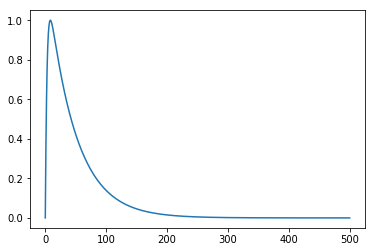

In [114]:
t, p = ExpSyn(3, 45)
plt.plot(t, p)

In [202]:
np.random.seed(10100)

n_exc = 225
n_inh = 75

# set PN cell type & cells parameter
params_pn = {'tau':20, 'r':100, 'e':-65, 'vth':-40, 'vahp':-80, 'v0':-65, 'vmax':30, 't_refrac':10}
params_pv = {'tau':5, 'r':100, 'e':-65, 'vth':-50, 'vahp':-80, 'v0':-65, 'vmax':30, 't_refrac':0}
# set synapse type & parameter
syn_pn2pn = {'gmax':2e-3, 'tau_r':0.3, 'tau_d':1, 'e':0, 'd':1}
syn_pn2pv = {'gmax':1e-3, 'tau_r':0.3, 'tau_d':1, 'e':0, 'd':1}
syn_pv2pn = {'gmax':0, 'tau_r':1, 'tau_d':3, 'e':-80, 'd':1}
syn_pv2pv = {'gmax':1e-3, 'tau_r':1, 'tau_d':3, 'e':-80, 'd':1}

syn_type_params = [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv]

# set network parameters
ps = [[0.2, 0.2], [0.3, 0.3]] # PN->PN/Inh, Inh->PN/Inh

n_cells = n_exc + n_inh

cell_types = []
for i in range(n_cells):
    if i < n_exc:
        cell_types.append(0)
    else:
        cell_types.append(1)

cnt_map = CreateERnetwork(cell_types, ps)

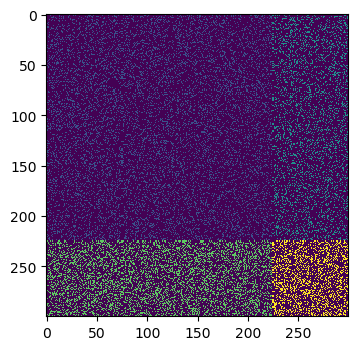

In [203]:
plt.figure(dpi=100)
plt.imshow(cnt_map)
plt.show()

In [204]:
out.print_nn_params('./parameter/', 'ntk', cell_types, cnt_map, [params_pn, params_pv], syn_type_params, d_noise=0.1, overwrite=True)

./parameter/ntk_cell.csv exists
./parameter/ntk_syn.csv exists
done



In [188]:
# ./runNetwork_w_current.exe --fdir ./parameter/ --prefix ntk --savename ./vcells_w_current.csv --tmax 1000 --dt 0.01 --s 0.15 -c --t0 100 --t1 120 --amp 1

In [205]:
times, vcells = out.readOut("./vcells_opt_v.csv")
times, icells = out.readOut("./vcells_opt_i.csv")

tspks = []
for i in range(vcells.shape[1]):
    tspks.append(times[vcells[:, i] == 30])

In [206]:
tspks_flat = []
spk_types = []
colors = []

# print(len(colors))
# 
for i, tspk in enumerate(tspks):
    tspks_flat = np.concatenate((tspks_flat, tspk))
    spk_types = np.concatenate((spk_types, np.ones(len(tspk))*i))
    
    if len(tspk) != 0:
        if i < n_exc:
            c = np.zeros([len(tspk), 3], dtype=np.uint8)
            c[:, 0] = 255
        else:
            c = np.zeros([len(tspk), 3], dtype=np.uint8)
            c[:, 2] = 255
        if len(colors) == 0:
            colors = c
        else:
            colors = np.vstack((colors, c))
# colors = colors.T

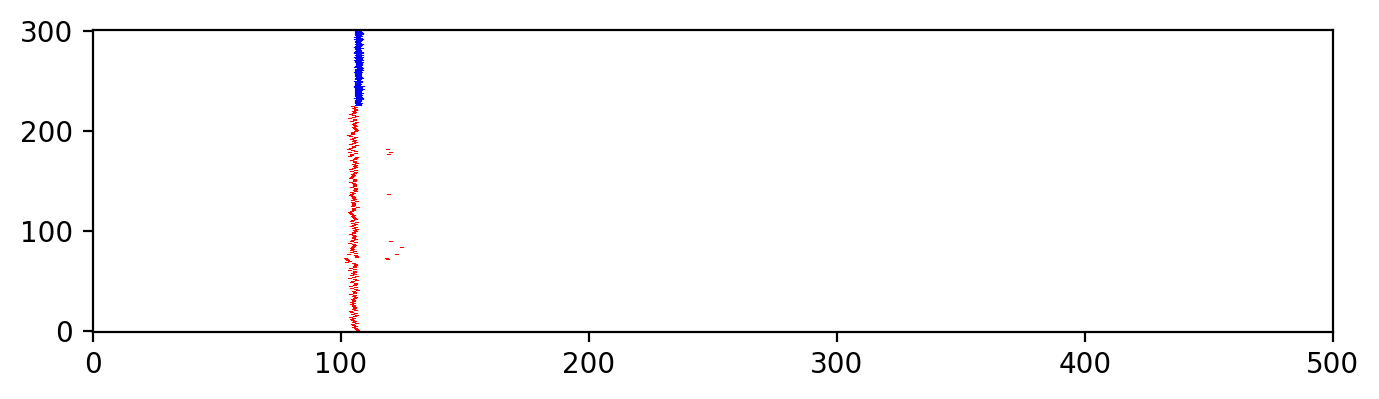

In [207]:
plt.figure(dpi=200, figsize=(8, 2))
# m = mpl.markers.MarkerStyle(marker='|', fillstyle='full')
# plt.scatter(tspks_flat, spk_types, s=0.1, edgecolor=None, c=colors/255, marker=m)

for i, tspk in enumerate(tspks):
    if i < n_exc:
        color = 'r'
    else:
        color = 'b'
    plt.vlines(tspk, i-0.2, i+0.2, color=color)

plt.xlim([0, times[-1]])
plt.ylim([-1, 301])

# plt.xlim([100, 120])
# plt.ylim([210, 260])

plt.show()

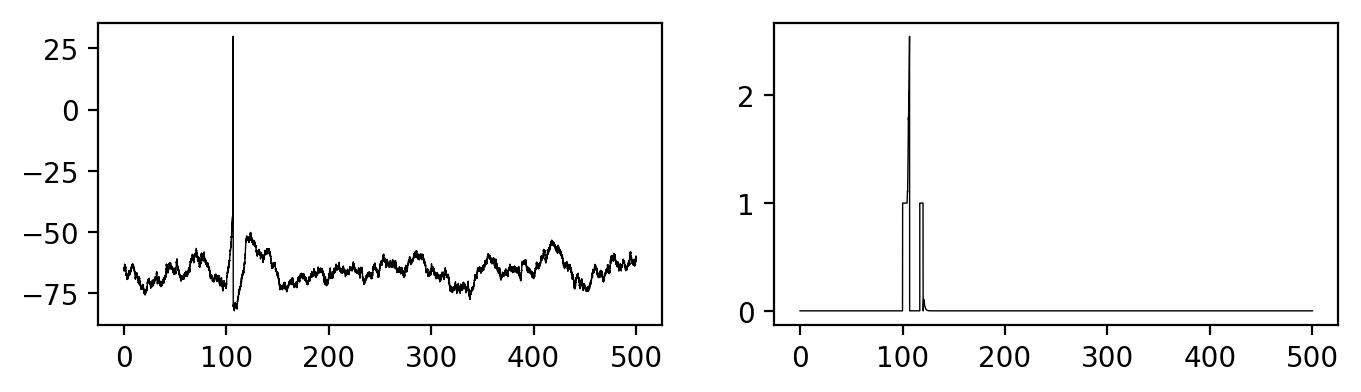

In [208]:
n=0

plt.figure(dpi=200, figsize=(8, 2))
plt.subplot(121)
plt.plot(times, vcells[:, n], 'k', lw=0.5)

plt.subplot(122)
plt.plot(times, icells[:, n], 'k', lw=0.5)

plt.show()

In [209]:
n = 0

ind = (times>100)&(times<150)
t = times[ind]
x = vcells[ind, n]
xi = icells[ind, n]

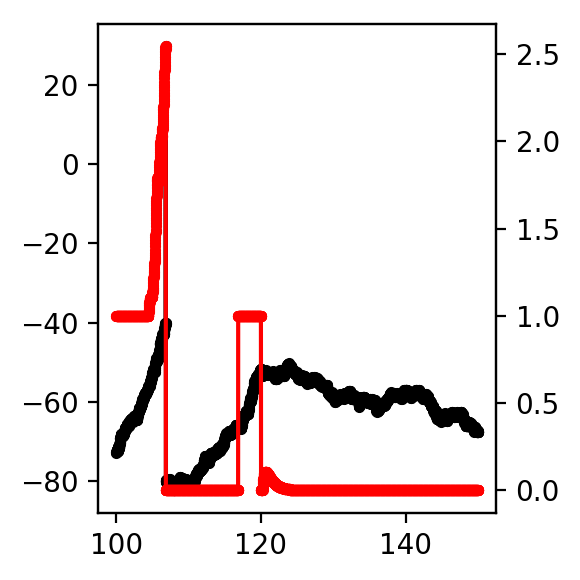

In [210]:
plt.figure(dpi=200, figsize=(3, 3))
# plt.subplot(121)
plt.plot(t, x, 'k.-')

plt.twinx()
plt.plot(t, xi, "r.-")

# plt.subplot(122)
# plt.plot(t, xi, "k,")

plt.tight_layout()
plt.show()